In [1]:
import re
import string
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
dir_data = '../data/nba_reg18/'

ds_sub = pd.DataFrame()
ds_com = pd.DataFrame()

nf_subs = 7 #7 files for submissions
nf_coms = 12 #12 files for comments

In [3]:
for icom in range(1, nf_subs+1):
    path_ds = dir_data + 'nba_submissions_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_sub = ds_sub.append(ds_cur).drop_duplicates()

In [4]:
for icom in range(1, nf_coms+1):
    path_ds = dir_data + 'nba_comments_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_com = ds_com.append(ds_cur).drop_duplicates()

In [5]:
print(ds_sub.shape)
print(ds_com.shape)

(92383, 6)
(2064767, 6)


In [6]:
# put submissions and comments together
ds = pd.concat([ds_sub[['author', 'flair', 'title', 'created']].rename(columns = {'flair':'team', 'title':'text'}),
                ds_com[['author', 'flair', 'text', 'created']].rename(columns = {'flair':'team'})],
               ignore_index = True)

In [7]:
# drop empty texts
ds.dropna(inplace = True)

In [8]:
print(ds.shape)

(1731127, 4)


### Standerdize Team Name

In [9]:
team_names = pd.read_csv('teams', names = ['name', 'abbrs'])
team_dict = team_names.set_index('name').to_dict()['abbrs']
team_fulls = team_names['name'].to_list()
team_abbrs = team_names['abbrs'].to_list()

In [10]:
def team2abbr(flair, team_dict, team_fulls, team_abbrs):
    # transform all flairs (team names, player names with team abbrs) into team abbrs only
    
    # team names
    for name in team_fulls:
        if name in flair:
            return team_dict[name]
    
    # player names with team abbrs
    for abbr in team_abbrs:
        if abbr in flair:
            return abbr
    
    # otherwise return original (bind into "others" later)
    return flair

In [11]:
# get rid of the weired pandas float nan
ds.loc[ds['team'].isnull().values, 'team'] = 'NONE'

In [12]:
# mapping to abbrev team name
ds['team'] = ds['team'].apply(team2abbr, args = [team_dict, team_fulls, team_abbrs])

In [13]:
print('No. Total:')
print(ds.shape)
ds = ds.loc[ds['team'].isin(team_abbrs), :]
print('No. for 31 Teams:')
print(ds.shape)

No. Total:
(1731127, 4)
No. for 31 Teams:
(1617815, 4)


In [14]:
#ds.to_csv('ds_orig.csv')

# Text Preprocessing

In [15]:
def preprocess_one(text, b_punct):
    # remove links and emojis
    cleaned1 = re.sub(r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', ' ', str(text))

    #replace special char like 🏀
    cleaned2 = cleaned1.encode('ascii', 'ignore').decode('ascii')
    
    #remove \n \t \r
    cleaned3 = cleaned2.translate(str.maketrans("\n\t\r", "   "))
    if b_punct:
        #replace punctuation with space
        cleaned3 = ''.join([c if c not in string.punctuation else ' ' for c in cleaned3])
    
    return cleaned3

In [16]:
#prep_text = ds['text'].apply(lambda x: preprocess_one(x, False))

In [17]:
#corpus = '. '.join(prep_text.to_list())
#f = open('txt_corpus.txt', 'w')
#f.write(corpus)
#f.close()

In [18]:
ds['text'] = ds['text'].apply(lambda x: preprocess_one(x, True))

# Use spacy to do name entity recognition

In [19]:
# see the other script: ../scripts/ner1.py

In [20]:
ner1 = pd.read_csv('entity1.csv', index_col = 0)
ner2 = pd.read_csv('entity2.csv', index_col = 0)
ner3 = pd.read_csv('entity3.csv', index_col = 0)

In [21]:
ner = pd.concat([ner1,ner2,ner3])

In [22]:
ds = ds.join(ner)

In [23]:
ds_sub = ds.loc[ds['entity'].notnull(),:]

In [24]:
print(ds.shape[0])
print(ds_sub.shape[0])

1617815
949634


In [25]:
post_count = ds_sub.groupby(['author'])['text'].count()

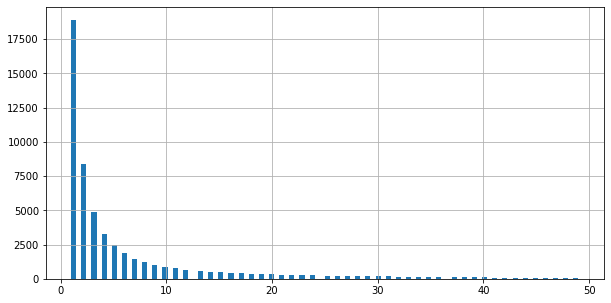

In [26]:
post_count.loc[post_count < 50].hist(bins=100, figsize=(10,5))

In [27]:
# concat all texts by users
ds_user = ds_sub.groupby(['author', 'team'])['text'].apply(lambda x: ' '.join(x)).reset_index()

In [28]:
# concat all entities by users
ds_user_ents = ds_sub.groupby(['author', 'team'])['entity'].apply(lambda x: ' '.join(x)).reset_index()

In [29]:
ds_user = ds_user.join(ds_user_ents['entity'])

# Visit History Data

In [30]:
ds_history = pd.DataFrame()
for i in range(1,6):
    ds_bot = pd.read_csv('bot'+str(i)+'_final.csv', index_col = 0)
    ds_history = ds_history.append(ds_bot)

In [31]:
ds_all = ds_user.merge(ds_history, how = 'left', left_on = 'author', right_on = 'user')

In [32]:
ds_all.dropna(inplace = True)

In [33]:
print(ds_all.shape)

(56878, 7)


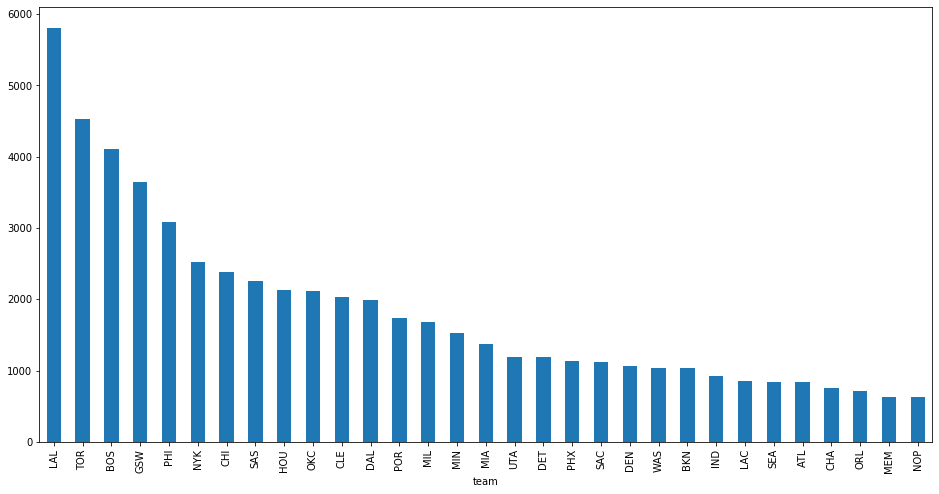

In [34]:
ds_all.groupby('team')['author'].count().sort_values(ascending=False).plot.bar(figsize=(16,8))

# Training and Testing set

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(ds_all[['text', 'entity', 'history']], 
                                                    ds_all['team'], test_size=0.20, random_state=0)

# MVP Model with TF-IDF and MultinomialNB (Text only)

In [37]:
# feature extraction using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [39]:
train_txt = tfidf.fit_transform(X_train['text'])
test_txt = tfidf.transform(X_test['text'])

In [40]:
from sklearn.naive_bayes import MultinomialNB

In [41]:
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_txt, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
# accuracy on training set
tfidf_nb.score(train_txt, y_train)

0.35103951474660455

In [43]:
# accuracy on testing set
tfidf_nb.score(test_txt, y_test)

0.30537974683544306

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

def cal_auc(model, X_test, y_test):
	'''
	calculate micro auc across all classes

	input
	-----
	obj model: model file with function predict_proba
	pd.df X_test: testing data features
	pd.df y_test: testing data labels

	output
	-----
	None
	'''

	# prediction probability
	y_test_prob = model.predict_proba(X_test)

	# one-hot encode 31 classes
	enc = OneHotEncoder()
	y_test_ohe = enc.fit_transform(y_test.values.reshape(-1, 1)).toarray()

	# Compute ROC curve and ROC area for each class
	n_classes = 31
	fpr = dict()
	tpr = dict()
	roc_auc = dict()
	for i in range(n_classes):
	    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_test_prob[:, i])
	    roc_auc[i] = auc(fpr[i], tpr[i])

	# calculate micro auc
	fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_test_prob.ravel())
	roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

	print('auc:')
	print(roc_auc['micro'])

In [45]:
cal_auc(tfidf_nb, test_txt, y_test)

auc:
0.8078593132959198


In [48]:
from sklearn.dummy import DummyClassifier

In [66]:
clf = DummyClassifier(random_state = 0, strategy = 'constant', constant = 0)

In [77]:
x = np.ones((500,1))

In [98]:
np.random.seed(0)
y = pd.Series(np.random.randint(31, size=500))

In [94]:
clf.fit(x, y)

DummyClassifier(constant=0, random_state=0, strategy='constant')

In [97]:
round(0.5060666666666667,2)

0.51

In [95]:
cal_auc(clf, x, y)

auc:
0.5060666666666667


/home/bearsun/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [43]:
pred_txt_logp = tfidf_nb.predict_log_proba(test_txt)

# Model with TF-IDF and MultinomialNB (Entity only)

In [44]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [48]:
train_txt = tfidf.fit_transform(X_train['entity'])
test_txt = tfidf.transform(X_test['entity'])

## With SMOTE

In [49]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=0).fit_resample(train_txt, y_train)

In [50]:
ent_tfidf_smote_nb = MultinomialNB()
ent_tfidf_smote_nb.fit(X_train_resampled, y_train_resampled)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
# accuray on balanced training set
ent_tfidf_smote_nb.score(X_train_resampled, y_train_resampled)

0.466275029303445

In [52]:
# accuracy on training set
ent_tfidf_smote_nb.score(train_txt, y_train)

0.42492637686255547

In [53]:
# accuracy on testing set
ent_tfidf_smote_nb.score(test_txt, y_test)

0.3628691983122363

In [54]:
cal_auc(ent_tfidf_smote_nb, test_txt, y_test)

auc:
0.8004785430114015


In [55]:
pred_ent_logp = ent_tfidf_smote_nb.predict_log_proba(test_txt)

# Entity + TextRank + CountVectorizer + MultinomialNB

In [110]:
f = open('kwords2.txt','r')
kwords = f.read()
f.close()

In [111]:
vocabulary = kwords.split('@')

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

In [113]:
vectorizer = CountVectorizer(vocabulary=vocabulary[:3000])

In [114]:
train_txt = vectorizer.fit_transform(X_train['entity'])
test_txt = vectorizer.transform(X_test['entity'])

In [115]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=0).fit_resample(train_txt, y_train)

In [116]:
from sklearn.naive_bayes import MultinomialNB

In [117]:
ent_txtrk_smote_nb = MultinomialNB()
ent_txtrk_smote_nb.fit(X_train_resampled, y_train_resampled)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [118]:
# accuray on balanced training set
ent_txtrk_smote_nb.score(X_train_resampled, y_train_resampled)

0.3444143125654559

In [119]:
# accuracy on training set
ent_txtrk_smote_nb.score(train_txt, y_train)

0.36545646345215593

In [120]:
# accuracy on testing set
ent_txtrk_smote_nb.score(test_txt, y_test)

0.3508263009845288

In [121]:
cal_auc(ent_txtrk_smote_nb, test_txt, y_test)

auc:
0.7889783840170175


In [80]:
pred_txtrk_logp = ent_txtrk_smote_nb.predict_log_proba(test_txt)

# Visit History Data

In [81]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [82]:
train_txt = tfidf.fit_transform(X_train['history'])
test_txt = tfidf.transform(X_test['history'])

In [83]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=0).fit_resample(train_txt, y_train)

In [84]:
from sklearn.naive_bayes import MultinomialNB

In [85]:
hist_smote_nb = MultinomialNB()
hist_smote_nb.fit(X_train_resampled, y_train_resampled)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [86]:
# accuray on balanced training set
hist_smote_nb.score(X_train_resampled, y_train_resampled)

0.68108835422143

In [87]:
# accuracy on training set
hist_smote_nb.score(train_txt, y_train)

0.6282800756010725

In [88]:
# accuracy on testing set
hist_smote_nb.score(test_txt, y_test)

0.5412271448663853

In [90]:
cal_auc(hist_smote_nb, test_txt, y_test)

auc:
0.895712165023807


In [91]:
pred_hist_logp = hist_smote_nb.predict_log_proba(test_txt)

## Ensemble: Text predict_prob + Entity predict_prob + Visit History

In [ ]:
print('Correlation between two predict_logp:')
print(np.corrcoef(pred_txt_logp.reshape(1,-1), pred_ent_logp.reshape(1,-1)))

In [ ]:
print('Correlation between two predict_logp:')
print(np.corrcoef(pred_txt_logp.reshape(1,-1), pred_txtrk_logp.reshape(1,-1)))

In [ ]:
print('Correlation between two predict_logp:')
print(np.corrcoef(pred_txt_logp.reshape(1,-1), pred_hist_logp.reshape(1,-1)))

In [ ]:
from matplotlib import cm

In [ ]:
# prediction pattern
plt.imshow(pred_txt_logp[:31,:], norm = cm.colors.Normalize(vmax=pred_txt_logp.max(), vmin=pred_txt_logp.min()))

In [ ]:
plt.imshow(pred_ent_logp[:31,:], norm = cm.colors.Normalize(vmax=pred_ent_logp.max(), vmin=pred_ent_logp.min()))

In [ ]:
plt.imshow(pred_txtrk_logp[:31,:], norm = cm.colors.Normalize(vmax=pred_ent_logp.max(), vmin=pred_ent_logp.min()))

In [ ]:
plt.imshow(pred_hist_logp[:31,:], norm = cm.colors.Normalize(vmax=pred_ent_logp.max(), vmin=pred_ent_logp.min()))

In [92]:
def custom_normalize(np_data):
    mx = np_data.max()
    mn = np_data.min()
    return (np_data-mn)/(mx-mn)

In [93]:
pred_comb = custom_normalize(pred_ent_logp) + custom_normalize(pred_txt_logp) + custom_normalize(pred_txtrk_logp) + custom_normalize(pred_hist_logp)

In [94]:
y_comb = y_test.to_frame().copy()

In [95]:
y_comb['pred'] = ent_tfidf_smote_nb.classes_[pred_comb.argmax(axis = 1)]

In [96]:
y_comb['cor'] = y_comb['pred'] == y_comb['team']

In [97]:
y_comb['cor'].mean()

0.5885196905766527

In [ ]:
# to do: fit the best linear combination of probs using training data

## Multi-class AUC

In [ ]:
# prediction probability
y_test_prob = tfidf_smote_nb.predict_proba(test_txt)

In [ ]:
y_test_smote_prob = tfidf_smote_nb.predict_proba(test_txt)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

In [ ]:
enc = OneHotEncoder()
y_test_ohe = enc.fit_transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = 31
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
print(roc_auc['micro'])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
n_classes = 31
fpr_smote = dict()
tpr_smote = dict()
roc_auc_smote = dict()
for i in range(n_classes):
    fpr_smote[i], tpr_smote[i], _ = roc_curve(y_test_ohe[:, i], y_test_smote_prob[:, i])
    roc_auc_smote[i] = auc(fpr_smote[i], tpr_smote[i])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkred',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr_smote[2], tpr_smote[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_smote[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Model for the webapp, trained on all data

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB

In [37]:
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [40]:
text = tfidf.fit_transform(ds_all['text'])

In [43]:
labels = ds_all['team']

In [44]:
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(text, labels)

In [47]:
tfidf_nb_app = MultinomialNB()
tfidf_nb_app.fit(X_resampled, y_resampled)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
tfidf_nb_app.score(text, labels)

0.43461443791975807

In [50]:
# dump both model and tf-idf to files
from joblib import dump

In [51]:
dump(tfidf_nb_app, 'tfidf_nb_app.joblib') 

['tfidf_nb_app.joblib']

In [52]:
dump(tfidf, 'tfidf.joblib')

['tfidf.joblib']